In [1]:

import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

current_dir = os.getcwd()
information_metrics_dir = os.path.dirname(current_dir)
sys.path.append(information_metrics_dir)

import src.utils.helper_functions as helper
import src.wrappers.spatial_prediction_calcium_base as sp
import src.utils.bootstrapped_estimation as be
import src.utils.normalizing_functions as norm

from src.data.data_loader import LoadData
from src.data.data_processing import ProcessData
from src.utils import pre_processing_functions as pre_process
import src.data.cell_model_base as cs_model

%matplotlib widget


- Parameters for Filename Creation and Saving:
    These parameters assist in constructing a filename and saving the results. If you do not wish to save the results and prefer to work with the object directly, you can ignore these settings by setting the 'saving' flag to False.
    - 'saving_string': Prefix used for creating the filename to save the results.
    - 'animal_id': Identifier for the animal.
    - 'dataset': Name of the dataset.
    - 'day': Session or day of the experiment.
    - 'neuron': Identifier for the neuron.
    - 'trial': Identifier for the trial.
    - 'saving_path': Directory path where the results will be saved.
    - 'saving': Boolean flag indicating whether to save the results (True) or not (False).

- Parameters for Signal and Tracking:
    - 'sampling_rate': The rate at which the signal and tracking data are sampled.
    - 'environment_edges': Coordinates defining the boundaries of the environment.

- Inclusion Criteria for Analysis:
    - 'min_time_spent': Minimum time an animal must spend in each xy bin to be considered.
    - 'min_visits': Minimum number of visits required to each xy bin.
    - 'min_speed_threshold': Minimum speed threshold in coordinate units for the analysis.

- Information Parameters:
    - 'x_bin_size': Size of x bins in coordinate units used to calculate mutual information.
    - 'y_bin_size': Size of y bins in coordinate units used to calculate mutual information.
    - 'nbins_cal': Number of calcium signal bins used to calculate mutual information.

    Note: for x,y bin size, you should input the bin size; for calcium signal, you input the total amount of bins that will equally slice calcium amplitude (min and max values of calcium signal).
    
- Surrogate Analysis Parameters:
    - 'shift_time': Time shift window (in seconds) for creating surrogate distributions by randomly shifting the signal from -shift_time to +shift_time.
    - 'num_cores': Number of CPU cores to be used for the analysis. Set to -1 to utilize all available cores.
    - 'num_surrogates': Number of surrogate distributions to generate.

- Place Field Parameters:
    - 'smoothing_size': Size of the smoothing area in bins for plotting place fields.
    - 'percentile_threshold': Percentile threshold used to determine place field boundaries based on surrogate distributions.
    - 'min_num_of_bins': Minimum number of bins required to define a place field.

Note: Ensure that the variables input_signal,time_vector, x_coordinates and y_coordinates are vectors of the same size. You may need to downsample or upsample your signal or xy tracking coordinates to match their dimensions.


# If you have pre-existing data, bypass the previous code cells and load the data directly
# This is useful if you want to avoid re-running the preceding setup and instead work with already available data


In [2]:
# Initialize loader
dataset = 'etter'
loader = LoadData(dataset)

# See what's available
# loader.list_available()
loader.show_jupyter_tree()


Dataset path resolved: /home/apolo/Documents/github_projects/information_metrics/data/etter


In [3]:
# Load session
# data = loader.load(experiment='linear_track')
data = loader.load(experiment='open_field')

x_coordinates = data['position']['x']
y_coordinates = data['position']['y']
time_vector = data['position']['time']
sampling_rate = data['sampling_rate']
environment_edges = data['environment_edges']
raw_signal = data['traces']['raw']
filtered_signal = data['traces']['filtered']
diff_signal = data['traces']['diff']
binary_signal = data['traces']['binary']
environment_edges


[[0, 50], [0, 45]]

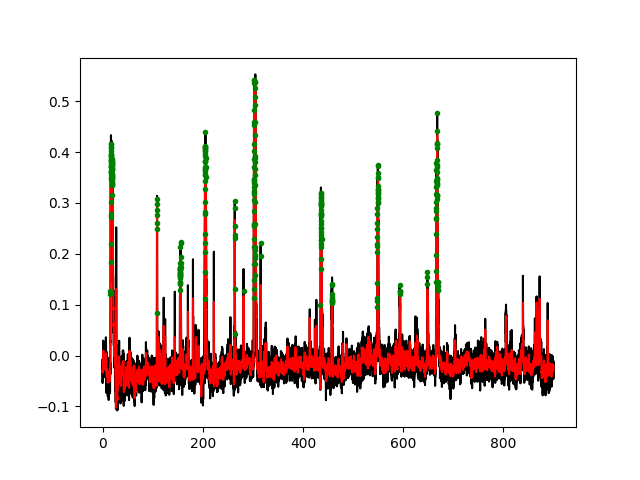

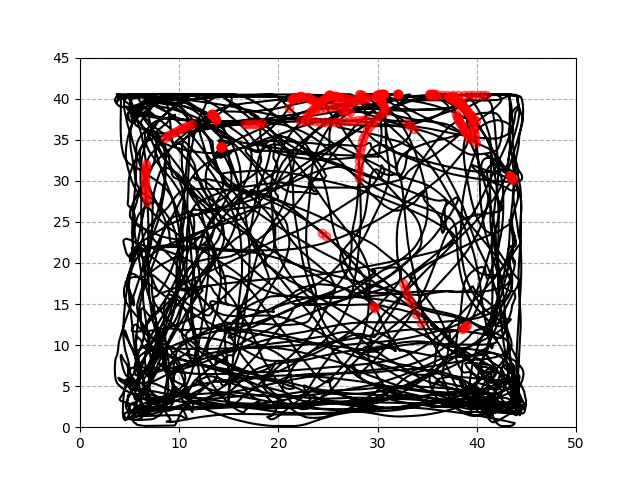

In [4]:

cell = 10
normalized_signal = norm.z_score_norm(raw_signal[cell,:])
normalized_signal = norm.z_score_norm(filtered_signal[cell,:])

signal_type = 'binary'
binary_signal = pre_process.preprocess_signal(normalized_signal, sampling_rate, signal_type, z_threshold = 2)

plt.figure()
plt.plot(time_vector,raw_signal[cell,:],'k')
plt.plot(time_vector,filtered_signal[cell,:],'r')
plt.plot(time_vector[binary_signal==1],raw_signal[cell,:][binary_signal==1],'g.')
plt.show()

plt.figure()
plt.plot(x_coordinates,y_coordinates,'k',zorder = 5)
plt.scatter(x_coordinates[binary_signal==1],y_coordinates[binary_signal==1],color = 'red', alpha=0.5, zorder = 10)
plt.xlim([environment_edges[0][0],environment_edges[0][1]])
plt.ylim([environment_edges[1][0],environment_edges[1][1]])
plt.grid(ls='--',zorder = 1)
plt.show()

normalized_signal = norm.robust_z_score_norm(filtered_signal,axis =1)

signal_type = 'filtered'
signal_data = ProcessData(normalized_signal, x_coordinates, y_coordinates, time_vector, sampling_rate, environment_edges)


In [5]:
# Arguments taken from the paper "Hippocampal Place Fields Maintain a Coherent and
# Flexible Map across Long Timescales"

# signal_type = 'filtered'

# Create a dictionary to hold input parameters for further processing
input_dict = {
# Construct the filename and other identifiers for saving the results
'saving_string' : 'SpatialMetrics.' + signal_type,  # Prefix for the filename
'animal_id' : 'NeuronModel',  # Identifier for the animal or model
'dataset' : 'Simulation',  # Name of the dataset
'day' : 1,  # Day or session number
'neuron' : 1,  # Neuron identifier
'trial' : None,  # Trial identifier (optional, can be None)
'saving_path' : None,  # Directory path for saving results (optional, can be None)
'saving' : False,  # Flag indicating whether to save the results (False means no saving)
'overwrite': False, # Flag indicating whether to overwrite already saved file 
'signal_type' : signal_type,

# Set inclusion criteria for the analysis
'min_time_spent' : 0.05,  # Minimum time an animal must spend in each xy bin in time_vector units (usually, in seconds)
'min_visits' : 1,  # Minimum number of visits required in each xy bin
'min_speed_threshold' : 1,  # Minimum speed threshold (in coordinate units [e.g., cm, pixels])
'speed_smoothing_sigma' : 0.5,  # Std of the gaussian smooth. Units is the same as time vector (seconds, for instance)

# Set parameters for plotting and spatial information calculation
'x_bin_size' : 2,  # Size of x bins (in coordinate units [e.g., cm, pixels])
'y_bin_size' : 2,  # Size of y bins (in coordinate units [e.g., cm, pixels])
'map_smoothing_sigma_x' : 2.5,  # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps
'map_smoothing_sigma_y' : 2.5, # Size of the gaussian smoothing area (std in coordinate units [e.g., cm, pixels]) for plotting activity maps

# Set parameters for information calculation
'nbins_cal' : 10,  # amount of calcium signal bins in coordinate units (cm)

# Set parameters for surrogate analysis
'shift_time' : 200,  # Time shift window in seconds for creating surrogate distributions
'num_cores' : -1,  # Number of CPU cores to use (set to -1 to use all available cores)
'num_surrogates' : 80,  # Number of surrogate distributions to generate

'num_of_folds' : 10, 
'classifier_parameters' : {'gaussian_nb': {'priors': 'uniform'}}
}

spatial_prediction = sp.SpatialPrediction(**input_dict)
spatial_prediction_output = spatial_prediction.main(signal_data)


Processing Surrogates:   0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

File not saved!


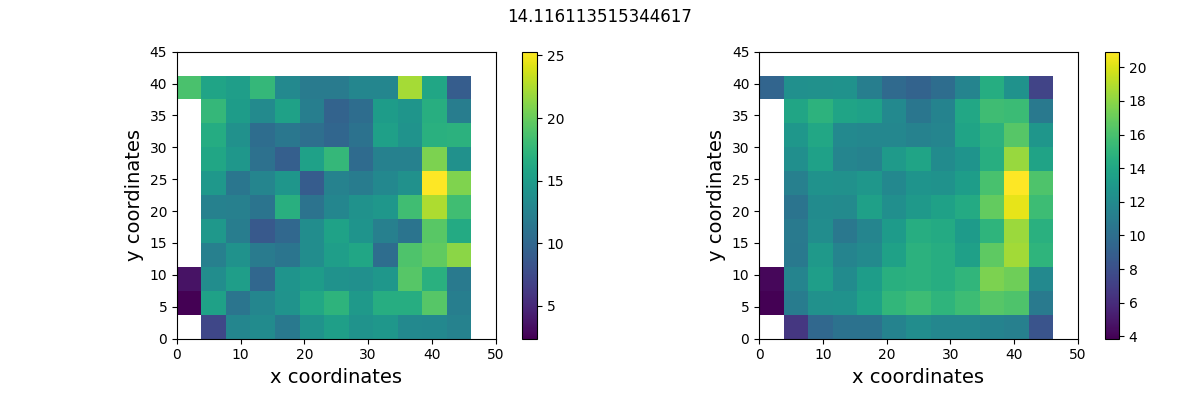

In [12]:

plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output['spatial_error'],cmap='viridis')
plt.colorbar()
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(1,2,2)
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_prediction_output['spatial_error_smoothed'],cmap='viridis')
plt.colorbar()
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal', adjustable='box')

plt.suptitle(spatial_prediction_output['mean_error'])
plt.tight_layout()
plt.show()


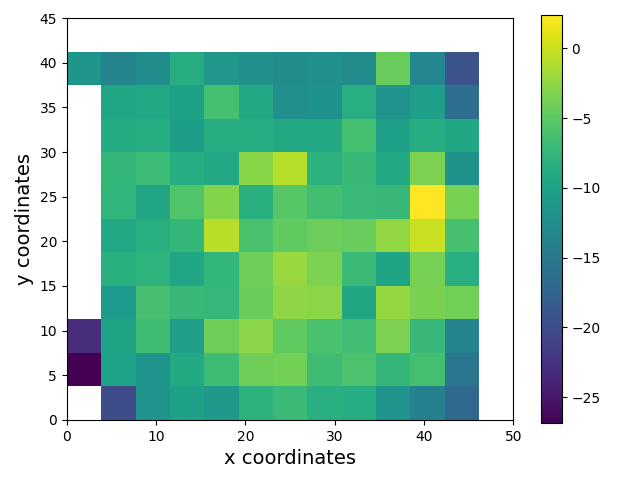

In [13]:
spatial_error = spatial_prediction_output['spatial_error'].copy()
spatial_error_shifted = spatial_prediction_output['spatial_error_shifted'].copy()
spatial_error_zscored = (spatial_error - np.nanmean(spatial_error_shifted,0))/np.nanstd(spatial_error_shifted,0)
spatial_error_zscored = (spatial_error - np.nanmean(spatial_error_shifted,0))

plt.figure()
plt.pcolormesh(spatial_prediction_output['x_center_bins'],spatial_prediction_output['y_center_bins'],spatial_error_zscored)
plt.colorbar()
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])

plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()

plt.show()


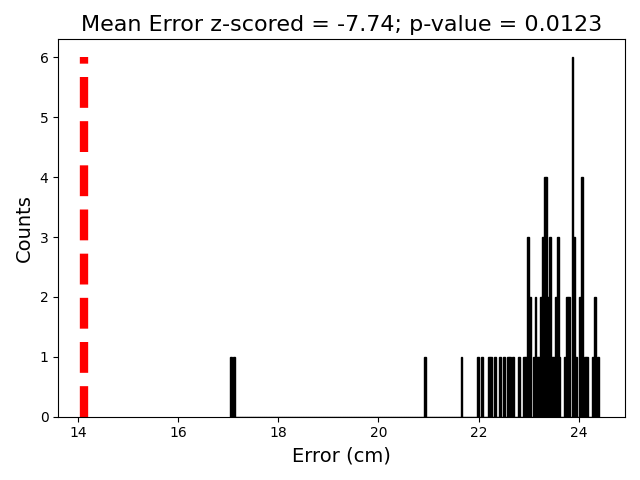

In [17]:

mean_error = spatial_prediction_output['mean_error']
counts,bins = np.histogram(spatial_prediction_output['mean_error_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([mean_error,mean_error],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mean Error z-scored = {0:.2f}; p-value = {1:.4f}".format(spatial_prediction_output['mean_error_zscored'],spatial_prediction_output['mean_error_pvalue']),fontsize=16)
plt.xlabel('Error (cm)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()

plt.show()



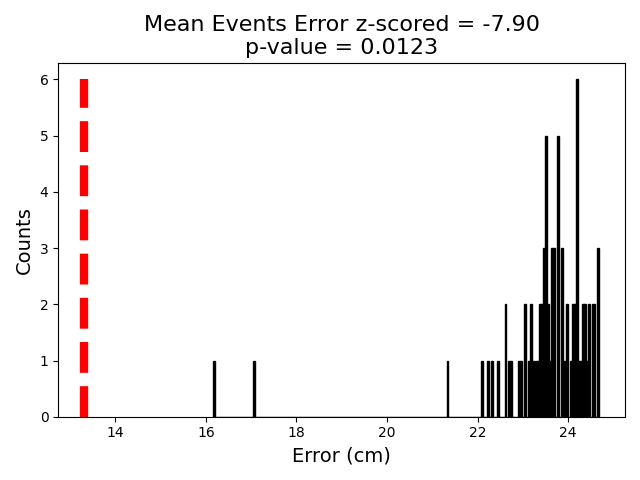

In [16]:

counts,bins = np.histogram(spatial_prediction_output['mean_events_error_shifted'],200)
bins_centers = bins[0:-1] + np.diff(bins)
bin_width = np.diff(bins_centers)[0]

plt.figure()
plt.bar(bins_centers,counts,color='black',width=bin_width,linewidth=1,edgecolor='black')
plt.plot([spatial_prediction_output['mean_events_error'],spatial_prediction_output['mean_events_error']],[0,np.max(counts)],'r--',linewidth=6)
plt.title("Mean Events Error z-scored = {0:.2f}\np-value = {1:.4f}".format(spatial_prediction_output['mean_events_error_zscored'],spatial_prediction_output['mean_events_error_pvalue']),fontsize=16)
plt.xlabel('Error (cm)',fontsize=14)
plt.ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()



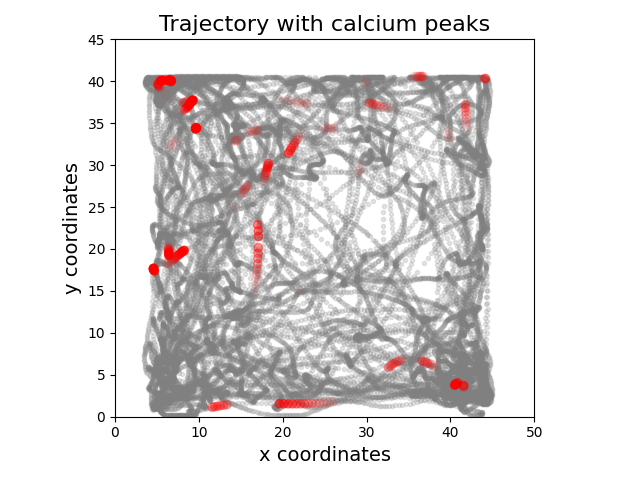

In [15]:
# The function normalizes peak amplitudes and uses them to set the transparency of each peak.
# Peaks with higher amplitudes are darker (less transparent) in the plot.
cell = 9
x_peaks_location = signal_data.peaks_x_location[cell]
y_peaks_location = signal_data.peaks_y_location[cell]
events_amplitude = signal_data.peaks_amplitude[cell]

events_amplitude_norm = (events_amplitude-np.nanmin(events_amplitude))/(np.nanmax(events_amplitude)-np.nanmin(events_amplitude))
if np.all(np.isnan(events_amplitude_norm)):
    events_amplitude_norm = np.ones(events_amplitude_norm.shape[0])

plt.figure()
plt.plot(signal_data.x_coordinates,signal_data.y_coordinates,color='gray',ls='',marker='.',alpha=0.2, zorder=1)
plt.scatter(x_peaks_location,y_peaks_location,alpha=events_amplitude_norm,color='red',zorder=10)
plt.title('Trajectory with calcium peaks',fontsize=16)
plt.xlabel('x coordinates',fontsize=14)
plt.ylabel('y coordinates',fontsize=14)
plt.xlim([signal_data.environment_edges[0][0],signal_data.environment_edges[0][1]])
plt.ylim([signal_data.environment_edges[1][0],signal_data.environment_edges[1][1]])
plt.gca().set_aspect('equal')  # optional: equal aspect ratio for x/y

plt.tight_layout()
plt.show()
